<a href="https://colab.research.google.com/github/th4ruka/machine-learning/blob/main/models/gans/dc_gans/01_DCGAN_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Convolutional Generative Adversarial Network

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/dcgan">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/dcgan.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to generate images of handwritten digits using a [Deep Convolutional Generative Adversarial Network](https://arxiv.org/pdf/1511.06434.pdf) (DCGAN). The code is written using the [Keras Sequential API](https://www.tensorflow.org/guide/keras) with a `tf.GradientTape` training loop.

## What are GANs?
[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) (GANs) are one of the most interesting ideas in computer science today. Two models are trained simultaneously by an adversarial process. A *generator* ("the artist") learns to create images that look real, while a *discriminator* ("the art critic") learns to tell real images apart from fakes.

![A diagram of a generator and discriminator](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan1.png?raw=1)

During training, the *generator* progressively becomes better at creating images that look real, while the *discriminator* becomes better at telling them apart. The process reaches equilibrium when the *discriminator* can no longer distinguish real images from fakes.

![A second diagram of a generator and discriminator](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan2.png?raw=1)

This notebook demonstrates this process on the MNIST dataset. The following animation shows a series of images produced by the *generator* as it was trained for 50 epochs. The images begin as random noise, and increasingly resemble hand written digits over time.

![sample output](https://tensorflow.org/images/gan/dcgan.gif)

To learn more about GANs, see MIT's [Intro to Deep Learning](http://introtodeeplearning.com/) course.

### Setup

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.15.0'

In [ ]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-uuessm1o
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-uuessm1o
  Resolved https://github.com/tensorflow/docs to commit 75b2672b5bed8ca0995663536db84bd9a39b8896
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.5.3.31743-py3-none-any.whl size=182531 sha256=e2e5701621f36ed8a41b51faabd221c8dbfca186bc2e888c207ce600a03bdadf
  Stored in directory: /tmp/pip-ephem-wheel-cache-nldegs0k/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data() #ignoring test set for now

11490434/11490434 [==============================] - 0s 0us/step


1. **Reshaping the Data**:
   - `train_images.reshape(train_images.shape[0], 28, 28, 1)` changes the shape of `train_images` from `(60000, 28, 28)` to `(60000, 28, 28, 1)`.
   - This adds an extra dimension to the data, which is necessary because convolutional neural networks (CNNs) in TensorFlow and other deep learning frameworks typically expect images to have a shape that includes the number of channels (e.g., grayscale images have 1 channel, RGB images have 3 channels).
   - By reshaping to `(60000, 28, 28, 1)`, each image is now explicitly treated as having a single channel (grayscale).

2. **Changing the Data Type**:
   - `.astype('float32')` converts the pixel values of `train_images` to `float32` data type.
   - This is important because neural networks usually expect input data to be in floating-point format, not integer format.
   - The original pixel values of MNIST images are in the range [0, 255] (unsigned 8-bit integers), and converting them to `float32` is a preparatory step for further normalization.

3. **Normalization**:
   - After converting to `float32`, the data is typically normalized to a range [0, 1] by dividing by 255. This makes the training process more stable and efficient.
   - This normalization step might look like: `train_images /= 255.0`.

Overall, the purpose of this line of code is to prepare the MNIST training images for input into a CNN by ensuring they have the correct shape and data type.

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

### Batching
Batching involves grouping a fixed number of data samples together to form a batch. The key benefits are:

1. **Efficiency**: Processing data in batches is more efficient than processing one sample at a time due to the parallelism and vectorization capabilities of modern hardware (e.g., GPUs).
2. **Stability**: Batching helps stabilize the training process by averaging the gradient over several samples, which can reduce the variance of the updates to the model's parameters.
3. **Memory Management**: Training on the entire dataset at once can be computationally prohibitive due to memory constraints. Batching allows training on smaller subsets of the data that fit into memory.

### Shuffling
Shuffling involves randomly reordering the data samples before each epoch of training. The key benefits are:

1. **Breaking Correlations**: Shuffling helps break any inherent ordering in the dataset that might otherwise introduce unwanted correlations, which could negatively affect the training process.
2. **Reducing Overfitting**: Shuffling can reduce the risk of overfitting by ensuring that the model does not learn the order of the data.
3. **Improved Generalization**: By presenting the data in different orders, the model is exposed to a more varied sequence of examples, which can improve its ability to generalize to unseen data.



In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

- `tf.data.Dataset.from_tensor_slices(train_images)`: This creates a `tf.data.Dataset` object from the `train_images` array, where each element of the dataset corresponds to one image.
- `.shuffle(BUFFER_SIZE)`: This randomly shuffles the dataset. `BUFFER_SIZE` determines the size of the shuffle buffer, which affects how thoroughly the data is shuffled. A larger buffer size means better shuffling but requires more memory.
- `.batch(BATCH_SIZE)`: This groups the dataset into batches of size `BATCH_SIZE`. Each batch will contain `BATCH_SIZE` samples.

### Purpose
The combined effect of batching and shuffling is to prepare the dataset for efficient and effective training by ensuring that each batch of data the model sees is well-mixed and appropriately sized for the computational resources available. This helps in training a more robust and generalized model.

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    #The reason for this specific number of neurons is to produce a 7x7x256 tensor from a 1D input vector.
    #This will be reshaped into a 3D tensor in the subsequent layers.
    #input shape is a 1D vector of 100 elements. (Latent vector)
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization()) #bias is not necessary since we use batch normalization (similar benefits)
    model.add(layers.LeakyReLU()) # non linearity

    #Reshapes this flat vector into a 3D tensor with dimensions 7x7x256. This forms the initial "image"
    model.add(layers.Reshape((7, 7, 256))) #height x width x number of channels (feature maps)
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

1. **First Conv2DTranspose Layer**:
    ```python
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    ```
    - **128 filters**: This layer will output a tensor with 128 channels.
    - **Kernel size (5, 5)**: The size of the filters.
    - **Strides (1, 1)**: This keeps the spatial dimensions the same (7x7).
    - **Padding 'same'**: Ensures the output dimensions match the input dimensions (7x7).

2. **Second Conv2DTranspose Layer**:
    ```python
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    ```
    - **64 filters**: This layer will output a tensor with 64 channels.
    - **Kernel size (5, 5)**: The size of the filters.
    - **Strides (2, 2)**: This upsamples the spatial dimensions from 7x7 to 14x14.
    - **Padding 'same'**: Ensures the output dimensions are correctly upsampled to 14x14.

3. **Final Conv2DTranspose Layer**:
    ```python
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    ```
    - **1 filter**: This layer will output a tensor with 1 channel, suitable for a grayscale image.
    - **Kernel size (5, 5)**: The size of the filters.
    - **Strides (2, 2)**: This upsamples the spatial dimensions from 14x14 to 28x28.
    - **Padding 'same'**: Ensures the output dimensions are correctly upsampled to 28x28.
    - **Activation 'tanh'**: The `tanh` activation function scales the output to the range [-1, 1], which is typical for DCGANs.


Use the (as yet untrained) generator to create an image.

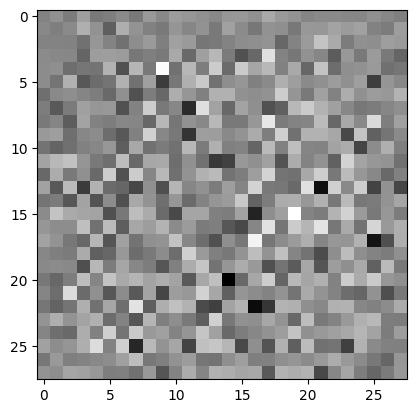

In [ ]:
generator = make_generator_model()

# 1x100 tensor
noise = tf.random.normal([1, 100]) #batch_size = 1, 100 dimensional vector
generated_image = generator(noise, training=False) #generated image tensor

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Purpose of Each Part\
* `generated_image[0]`: Accesses the first image in the batch.
* `[:, :]`: Selects all rows and columns of the image.
* `[0]`: Selects the first (and only) channel of the image, since it's a grayscale image.
* `cmap='gray'`: Ensures that the image is displayed in grayscale, which is suitable for MNIST images (handwritten digits).

### The Discriminator

The discriminator is a CNN-based image classifier.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00129008]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
#from_logits=True: This indicates that the input to the binary
#cross-entropy loss function consists of raw logits rather than probabilities.

### The `from_logits` Parameter

- **Logits**: In neural network terminology, "logits" refer to the raw, unnormalized scores output by the last layer of the model before applying any activation function like sigmoid or softmax.
- **from_logits=True**: This indicates that the input to the binary cross-entropy loss function consists of raw logits rather than probabilities.

#### Why Use `from_logits=True`?

1. **Numerical Stability**: Using raw logits directly can be more numerically stable than using probabilities. When logits are used, TensorFlow can apply the sigmoid function internally in a way that avoids numerical issues, such as overflow or underflow.
2. **Efficiency**: It can be computationally more efficient because TensorFlow optimizes the combined operation of applying the sigmoid activation and computing the binary cross-entropy loss.

### Example with and without `from_logits`

#### Without `from_logits` (Probabilities)

If your model's output layer applies a sigmoid activation function, the outputs are probabilities, and you would use `from_logits=False`.

```python
model.add(layers.Dense(1, activation='sigmoid'))
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
```

In this case, the model output is already between 0 and 1 (probabilities), and the loss function expects these probability values.

#### With `from_logits` (Logits)

If your model's output layer does not apply a sigmoid activation function, the outputs are logits, and you would use `from_logits=True`.

```python
model.add(layers.Dense(1))  # No activation function here
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
```

In this case, the model output can be any real number, and the loss function will internally apply the sigmoid function to convert these logits to probabilities before computing the binary cross-entropy loss.

### Summary

The parameter `from_logits=True` in `tf.keras.losses.BinaryCrossentropy(from_logits=True)` indicates that the input to the loss function consists of raw logits, not probabilities. This allows TensorFlow to apply the sigmoid activation function internally in a numerically stable and efficient way, which is particularly useful in models like GANs where the discriminator outputs logits directly.

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [ ]:
def discriminator_loss(real_output, fake_output):
    # tf.ones_like(real_output) a tensor of ones with the same shape as real_output
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # tf.zeros_like(fake_output) a tensor of zeros with the same shape as fake_output
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

* The discriminator should output a value close to 1 for real images. The binary cross-entropy loss for real images is computed by comparing the discriminator's output on real images with a tensor of ones.
* The discriminator should output a value close to 0 for fake images. The binary cross-entropy loss for fake images is computed by comparing the discriminator's output on fake images with a tensor of zeros.

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [ ]:
#lr = 0.0001
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

 # Save checkpoint every epoch
    # checkpoint.save(file_prefix=checkpoint_prefix)
# Restore
    # checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Define the training loop


In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

* Functions annotated with `@tf.function` are "compiled" to TensorFlow graphs, optimizing performance by enabling graph-level optimizations and execution in C++ runtime.
* `tf.GradientTape` is used to record operations for automatic differentiation. These tapes will track the computations to later compute gradients for backpropagation.
* `generator(noise, training=True)` generates a batch of fake images from the noise input. The training=True argument ensures the generator behaves correctly during training (e.g., applying dropout if used).
* `discriminator(images, training=True)` gets the discriminator's predictions for the real images.
* `discriminator(generated_images, training=True)` gets the discriminator's predictions for the fake images generated by the generator.
* `gen_tape.gradient(gen_loss, generator.trainable_variables)`: Computes the gradients of the generator's loss with respect to the generator's trainable variables.
* `disc_tape.gradient(disc_loss, discriminator.trainable_variables)`: Computes the gradients of the discriminator's loss with respect to the discriminator's trainable variables.
* `generator_optimizer.apply_gradients(...)`: Updates the generator's weights using the computed gradients.
* `discriminator_optimizer.apply_gradients(...)`: Updates the discriminator's weights using the computed gradients.

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

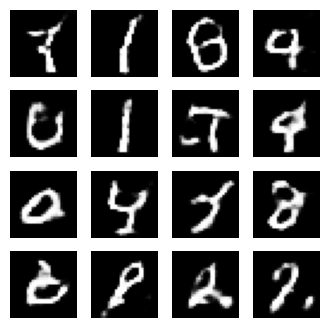

In [ ]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

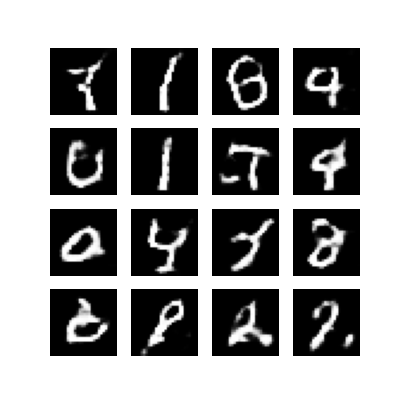

In [ ]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-26-56bb6d34be2e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-26-56bb6d34be2e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



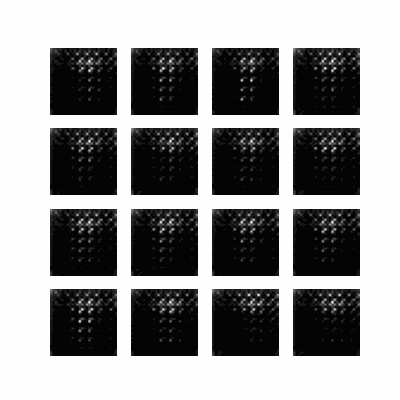

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

## Next steps


This tutorial has shown the complete code necessary to write and train a GAN. As a next step, you might like to experiment with a different dataset, for example the Large-scale Celeb Faces Attributes (CelebA) dataset [available on Kaggle](https://www.kaggle.com/jessicali9530/celeba-dataset). To learn more about GANs see the [NIPS 2016 Tutorial: Generative Adversarial Networks](https://arxiv.org/abs/1701.00160).
